#  Thesis: Crime Prediction in Bangladesh

In [25]:
import pandas as pd # panda's nickname is pd
import numpy as np
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from  sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import binarize
import matplotlib.pyplot as plot
from sklearn import linear_model
from IPython.display import Image 
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn import tree
import sklearn.preprocessing as prep
import pydotplus 
import math
from sklearn.linear_model import RidgeCV
import sklearn.linear_model as linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

###### Load the data_2.csv file into a dataframe object

In [26]:
communities_crime_df = pd.read_csv('crime_data.csv')

# Sanity test we have good data
communities_crime_df.head()

,UnitName,Fold,Dacoity,Robbery,Murder,SpeedyTrial,Riot,WomanAndChildRepression,Kidnapping,PoliceAssault,Burglary,Theft,OtherCases,ArmsAct,Explosive,Narcotics,Smuggling,ViolentCrimesPerPop
0,1,5,0.07,0.21,0.06,0.21,0.02,0.08,0.16,0.32,0.18,0.22,0.08,0.32,0.32,0.35,0.02,0.14
1,1,3,0.07,0.21,0.06,0.22,0.02,0.08,0.16,0.33,0.18,0.22,0.08,0.33,0.32,0.36,0.02,0.14
2,1,2,0.07,0.21,0.06,0.22,0.02,0.08,0.16,0.33,0.16,0.22,0.08,0.33,0.32,0.36,0.02,0.14
3,1,9,0.07,0.21,0.06,0.22,0.02,0.08,0.16,0.33,0.18,0.22,0.08,0.33,0.32,0.36,0.02,0.14
4,1,6,0.09,0.22,0.06,0.15,0.28,0.07,0.18,0.19,0.26,0.25,0.07,0.13,0.27,0.18,0.03,0.11


### First algo: Decision Trees
---
#### Create a new field “highCrime” which is true if the crime rate per capita (ViolentCrimesPerPop) is greater than 0.1, and false otherwise. What are the percentage of positive and negative instances in the dataset?

In [27]:
def setHighCrime(df):
    '''Function to set value of highCrime depending on ViolentCrimesPerPop'''
    if df['ViolentCrimesPerPop'] > 0.1:
        return True
    else:
        return False
    
# Adding a new field "highCrime"
communities_crime_df['highCrime'] = communities_crime_df.apply(setHighCrime, axis=1)

# Calculating the percentage of positive and negative instances in the dataset
percentage_intances = communities_crime_df.groupby('highCrime').size() * 100 / len(communities_crime_df)
print(percentage_intances)
print("------------------")
print("Percentage Positive Instance = {}\nPercentage Negative Instance = {} ".format(percentage_intances[1],percentage_intances[0]))

highCrime
False    68.888889
True     31.111111
dtype: float64
------------------
Percentage Positive Instance = 31.1111111111
Percentage Negative Instance = 68.8888888889 


#### Using DecisionTreeClassifier to learn a decision tree to predict highCrime on the entire dataset
---
##### What are the training accuracy, precision, and recall for this tree?

In [28]:
#Dropping non-predictive fields as well as ViolentCrimesPerPop field 
X = communities_crime_df.drop('ViolentCrimesPerPop', axis=1).drop('UnitName', axis=1).drop('Fold', axis=1).drop('highCrime', axis=1)
features = list(X.columns)
y = communities_crime_df["highCrime"]


# First, we tried by not defining the max depth
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X,y)
predicted = dt_clf.predict(X[features])
recall_score = metrics.recall_score(communities_crime_df['highCrime'], predicted)
precision_score = metrics.precision_score(communities_crime_df['highCrime'], predicted)
accuracy_score = metrics.accuracy_score(communities_crime_df['highCrime'], predicted)
print("Training Accuracy = {} Precision = {} Recall = {}".format(accuracy_score,precision_score,recall_score))

Training Accuracy = 1.0 Precision = 1.0 Recall = 1.0


#### The scores values shows overfitting so we can define max_depth to avoid the complexity of the tree and to reach a point from where there is a decrease in the cross validation performance.

In [29]:
for depth in range(1,10):
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    if tree_clf.fit(X,y).tree_.max_depth < depth:
        break
    score = np.mean(cross_val_score(tree_clf, X, y,scoring='accuracy', cv=10, n_jobs=1))
    print("Depth: %i Accuracy: %.3f" % (depth,score))

Depth: 1 Accuracy: 0.954
Depth: 2 Accuracy: 0.962
Depth: 3 Accuracy: 0.954
Depth: 4 Accuracy: 0.954


#### We can see that the point up to which the performance is increasing is the depth 4. We can specify the depth and witness the results.

In [30]:
dt_clf = DecisionTreeClassifier(max_depth=3)
dt_clf.fit(X,y)
#Predicting 
pred_dt= dt_clf.predict(X)
dt_accuracy= metrics.accuracy_score(communities_crime_df['highCrime'], pred_dt)
dt_precision= metrics.precision_score(communities_crime_df['highCrime'], pred_dt)
dt_recall= metrics.recall_score(communities_crime_df['highCrime'], pred_dt)
print("Accuracy for DT =",dt_accuracy)
print("Precision for DT =",dt_precision)
print("Recall for DT =",dt_precision)

('Accuracy for DT =', 0.9925925925925926)
('Precision for DT =', 0.9767441860465116)
('Recall for DT =', 0.9767441860465116)


#### What are the main features used for classification? 

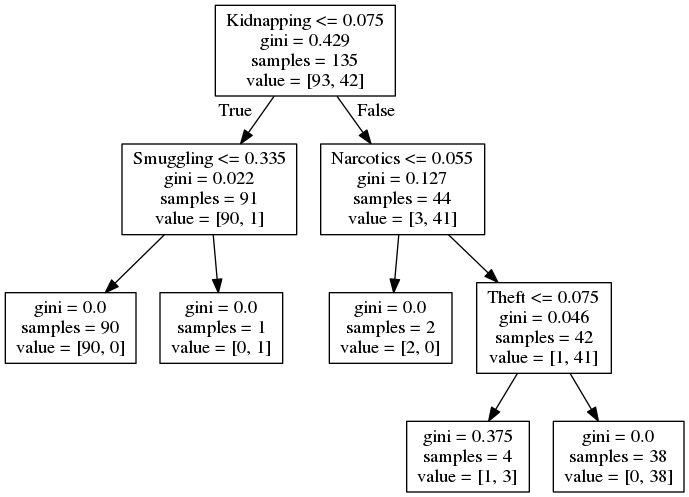

In [31]:
dot_data = tree.export_graphviz(dt_clf, out_file=None,feature_names=list(X))

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [32]:
# We can check the main features used for classification by checking the feature importance, the higher the value,
# more important the feature would be.
# We can sort the importance scores in descending order and take the top most.
importances=dt_clf.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
# We have taken the top 5 feature 
print("The main features used for classification")
print(X.columns[indices[:5]])
print("Top main feature is",X.columns[indices[:1]][0])

Feature ranking:
The main features used for classification
Index([u'Kidnapping', u'Narcotics', u'Smuggling', u'Theft', u'Explosive'], dtype='object')
('Top main feature is', 'Kidnapping')


#### The top main feature is Kidnapping because it is the split point of the tree. 

####  Now apply cross-validation (cross_val_score) to do 10-fold cross-validation to estimate the out-of-training accuracy of decision tree learning for this task.
---
##### What are the 10-fold cross-validation accuracy, precision, and recall?

In [33]:

# Applying 10 fold cross validation
dt_cv_accuracy = cross_val_score(dt_clf, X, y, cv=10).mean()
dt_cv_precision= cross_val_score(dt_clf, X, y, cv=10, scoring='precision').mean()
dt_cv_recall = cross_val_score(dt_clf, X, y, cv=10, scoring='recall').mean()
print("Cross Validation Accuracy DT:", dt_cv_accuracy)
print("Cross Validation Recall DT:", dt_cv_precision)
print("Cross Validation Precision DT:", dt_cv_recall)

('Cross Validation Accuracy DT:', 0.9461538461538461)
('Cross Validation Recall DT:', 0.9266666666666667)
('Cross Validation Precision DT:', 0.95)


### Second algo:  Linear Classification
---
#### Using GaussianNB to learn a Naive Bayes classifier to predict highCrime.
---
##### What is the 10-fold cross-validation accuracy, precision, and recall for this method?

In [34]:
# Using GaussianNB
gaussian_clf = GaussianNB()
gaussian_clf.fit(X, y)

# Applying 10 fold cross validation
gaussian_accuracy = cross_val_score(gaussian_clf, X, y, cv=10).mean()
gaussian_precision= cross_val_score(gaussian_clf, X, y, cv=10, scoring='precision').mean()
gaussian_recall = cross_val_score(gaussian_clf, X, y, cv=10, scoring='recall').mean()
print("Accuracy for gaussian :", gaussian_accuracy)
print("Recall for gaussian:", gaussian_recall)
print("Precision for gaussian:", gaussian_precision)

('Accuracy for gaussian :', 0.9384615384615385)
('Recall for gaussian:', 0.975)
('Precision for gaussian:', 0.9071428571428571)


##### What are the 10 most predictive features? 

In [35]:
df_predictiveFeature = communities_crime_df.drop('UnitName', axis=1).drop('Fold', axis=1)

dictPredFeature = {}
# Collecting data for the two classes
true_df = X[df_predictiveFeature['highCrime'] == 1]
false_df = X[df_predictiveFeature['highCrime'] == 0]
for column in X:
    mean_true = true_df[column].mean()
    mean_false = false_df[column].mean()
    var_true = true_df[column].var()
    var_false = false_df[column].var()
    if(column != 'highCrime'):
        predScore = abs((mean_true - mean_false))/(math.sqrt(var_true)+math.sqrt(var_false))
        dictPredFeature[column] = predScore
most_pred_features = sorted(dictPredFeature.items(), key=lambda x: x[1])[-10:]
for i in most_pred_features:
    print(i)

('Murder', 1.1747683660888069)
('OtherCases', 1.2060148838668037)
('ArmsAct', 1.303302078361282)
('WomanAndChildRepression', 1.3119724479275952)
('Narcotics', 1.3861516053309633)
('SpeedyTrial', 1.3893903596827435)
('Robbery', 1.447423646828152)
('Burglary', 1.4477299537550992)
('Theft', 1.6172969957207728)
('Kidnapping', 1.8205310099198875)


#### How do these results compare with our results from decision trees, above?

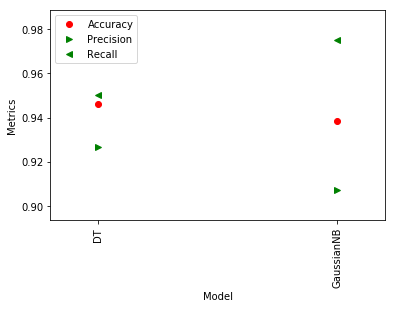

In [36]:

labels = ["DT" ,"GaussianNB"]
acc_list = [dt_cv_accuracy,gaussian_accuracy]
pre_list = [dt_cv_precision,gaussian_precision]
re_list = [dt_cv_recall,gaussian_recall]

x_axis_range = range(2)
plt.xticks(x_axis_range, labels, rotation='vertical')
# plt.legend()

plt.plot(x_axis_range,acc_list,'ro',color="Red",label="Accuracy")
plt.plot(x_axis_range,pre_list,'>',color="green",label="Precision")
plt.plot(x_axis_range,re_list,'<',color="green",label="Recall")

plt.xlabel('Model')
plt.ylabel('Metrics')
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
legend = plt.legend()
plt.show()

#### Using LinearSVC to learn a linear Support Vector Machine model to predict highCrime.

In [37]:
linearsvmclf = svm.SVC(kernel='linear', C =1.0)
accuracy_svm = cross_val_score(linearsvmclf, X, y, cv=10, scoring='accuracy').mean()
precision_svm = cross_val_score(linearsvmclf, X, y, cv=10, scoring='precision').mean()
recall_svm = cross_val_score(linearsvmclf, X, y, cv=10, scoring='recall').mean()
print ('Accuracy for LinearSVC is', accuracy_svm)
print ('Precision for LinearSVC is', precision_svm)
print ('Recall for LinearSVC is', recall_svm)

('Accuracy for LinearSVC is', 0.9615384615384615)
('Precision for LinearSVC is', 0.9371428571428572)
('Recall for LinearSVC is', 0.975)


##### What are the 10 most predictive features? This can be measured by the absolute feature weights in the model.

In [38]:
linearsvmclf.fit(X,y)

linearsvmclf_coef_array = {}
count = 0
for i in X.columns:
    linearsvmclf_coef_array[i] = abs(linearsvmclf.coef_[0][count])
    count = count+ 1

most_predictive_features = sorted(linearsvmclf_coef_array.items(), key=lambda x: x[1])[-10:]
most_predictive_features

[('Robbery', 1.1042528904412219),
 ('Murder', 1.1267588049989943),
 ('Theft', 1.2018783004308609),
 ('Burglary', 1.216474961985452),
 ('SpeedyTrial', 1.3143742503245541),
 ('Smuggling', 1.444536323757958),
 ('Narcotics', 1.4470768139878962),
 ('Kidnapping', 1.638719916313227),
 ('ArmsAct', 1.7397644420163418),
 ('Explosive', 2.1281549882949835)]

 #### How do these results compare with our results from decision trees, above?

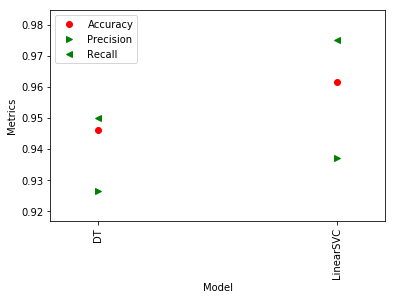

In [39]:
labels = ["DT" ,"LinearSVC"]
acc_list = [dt_cv_accuracy,accuracy_svm]
pre_list = [dt_cv_precision,precision_svm]
re_list = [dt_cv_recall,recall_svm]

x_axis_range = range(2)
plt.xticks(x_axis_range, labels, rotation='vertical')
# plt.legend()

plt.plot(x_axis_range,acc_list,'ro',color="Red",label="Accuracy")
plt.plot(x_axis_range,pre_list,'>',color="green",label="Precision")
plt.plot(x_axis_range,re_list,'<',color="green",label="Recall")

plt.xlabel('Model')
plt.ylabel('Metrics')
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
legend = plt.legend()
plt.show()

#### Using 10-fold cross-validation, what is the estimated meansquared- error (MSE) of the model?

In [40]:
Y = communities_crime_df['ViolentCrimesPerPop']
linear_regression = LinearRegression()
#df = df.drop('highCrime', 1)
mean_sq_err= cross_val_score(linear_regression,X, Y,None,scoring='neg_mean_squared_error',cv=10)
print("Estimated meansquared- error (MSE) of the model is",np.abs(mean_sq_err.mean()))

('Estimated meansquared- error (MSE) of the model is', 3.5104200570706014e-05)
